In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.constants as c
import PyAstronomy.pyasl as pya

import metallicity as mt

get_planet_params()

get_rho_circ()

get_g()

get_e()

In [7]:
def get_T23(p, rp_earth, rs, T14, a, i):
    
    ing_eg = 2*pya.ingressDuration(a, rp_earth*11.2, rs, i, p)#rp needs to in jovian radii
    T23 = T14-ing_eg
    
    return T23

def get_T23_errs(T23_dist):
    
    x, cdf = mt.get_cdf(T23_dist)
    T23_sigma_minus = mt.find_sigma(x, cdf, "-")
    T23_sigma_plus = mt.find_sigma(x, cdf, "+")
    
    return T23_sigma_minus, T23_sigma_plus


def get_planet_params(p, rp_earth, rs, T14, T23):
    """Returns planet parameters in correct units.

    Parameters
    ----------
    p: float
        Planet orbital period (days)
    rp_earth: float
        Planet radius (earth radii)
    rs: float
        Stellar radius (solar radii)
    T14: float
        Total transit time - first to fourth contact (hours)
    a: float
        Planet semi-major axis (AU)
    i: float
        Orbital inclination (degrees)

    Returns
    -------
    p_seconds: float
        Orbital period (seconds)
    rprs: float
        Planet radius (stellar host radii)
    T14_seconds: float
        Total transit time - first to fourth contact (seconds)
    T23_seconds: float
        Full transit time - second to third contact (seconds)
    """

    rp = rp_earth*0.0091577
    rprs = rp/rs

    p_seconds = p*86400
    T14_seconds = T14*3600
    T23_seconds = T23*3600

    return p_seconds, rprs, T14_seconds, T23_seconds


def get_rho_circ(rprs, T14, T23, p):
    """Returns stellar density, assuming a perfectly circular planetary orbit.

    Parameters
    ----------
    rprs: float
        Planet radius (stellar host radii)
    T14: float
        Total transit time - first to fourth contact (seconds)
    T23: float
        Full transit time - second to third contact (seconds)
    p: float
        Orbital period (seconds)

    Returns
    -------
    rho_circ: float
        Stellar density, assuming a circular orbit (kg/m^3)
    """
    delta = rprs**2
    num1 = 2*delta**(1/4)
    den1 = np.sqrt(T14**2- T23**2)
    term1 = (num1/den1)**3

    num2 = 3*p
    den2 = c.G*c.pi**2
    term2 = num2/den2

    rho_circ = term1*term2

    return rho_circ


def get_g(rho_circ, rho_star):
    """Gets g

    Parameters
    ----------
    rho_circ: float
        Stellar density, assuming a circular orbit (kg/m^3)
    rho_star: float
        Stellar density, calculated from Kepler/Gaia/spectroscopy (kg/m^3)

    Returns
    -------
    g: float
        Cube root of ratio between rho_circ and rho_star
    """
    g = np.cbrt(rho_c/rho_star)
    return g


def get_e(g, w):
    """Gets eccentricity (from photoeccentric effect)

    Parameters
    ----------
    g: float
        Cube root of ratio between rho_circ and rho_star
    w: float
        Angle of apoapse or periapse (?) (degrees, -90 < w < 90)

    Returns
    -------
    e: float
        Eccentricity of planet orbit
    """
    e = (np.sqrt(2)*(np.sqrt(2*g**4 - g**2*np.cos(2*w) - g**2 - 2*np.sin(w))))/(2*(g**2 + np.sin(w)**2))
    return e

In [8]:
#Kepler planets with spectroscopy
rho_lum = pd.read_csv('/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Data/rhos/rho_lum.csv')

# ALL Kepler planets from exo archive
planets = pd.read_csv('/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Data/exoplanetarchive/cumulative_kois.csv')

In [9]:
spectplanets = planets[planets['kepid'].isin(list(rho_lum.columns))]

In [17]:
per_dist = mt.asymmetric_gaussian(2, 1, -1, 30000)

(array([  15.,  204., 1247., 4794., 9033., 8804., 4551., 1179.,  159.,
          14.]),
 array([-2.14048899, -1.3084293 , -0.4763696 ,  0.3556901 ,  1.1877498 ,
         2.01980949,  2.85186919,  3.68392889,  4.51598858,  5.34804828,
         6.18010798]),
 <a list of 10 Patch objects>)

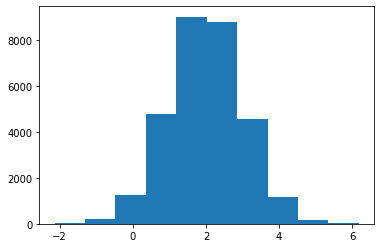

In [18]:
plt.hist(per_dist)

In [37]:
from tqdm import tqdm

In [ ]:
for targ in spectplanets.itertuples():
    
    rhos = rho_lum[str(targ.kepid)].dropna()

    per_dist = mt.asymmetric_gaussian(targ.koi_period, targ.koi_period_err1, targ.koi_period_err2, len(rhos))
    
    rp_earth_dist = mt.asymmetric_gaussian(targ.koi_srad, targ.koi_srad_err1, targ.koi_srad_err2, len(rhos))
    rs_dist = mt.asymmetric_gaussian(targ.koi_prad, targ.koi_prad_err1, targ.koi_prad_err2, len(rhos))
    
    a = targ.koi_sma
    i = targ.koi_incl
    
    T14_dist = mt.asymmetric_gaussian(targ.koi_duration, targ.koi_duration_err1, targ.koi_duration_err2, len(rhos))
    T23_dist = np.zeros((len(rhos)))
    
    for i in tqdm(range(len(rhos))):
        T23_dist[i] = get_T23(per_dist[i], rp_earth_dist[i], rs_dist[i], T14_dist[i], a, i)
    plt.hist(T23_dist)
    plt.show()
    

 22%|██▏       | 6665/30506 [17:44<1:04:49,  6.13it/s]

In [ ]:
for i in range(len(rhos)): #for element in histogram for star 0:
    
    
    p_seconds, rprs, T14_seconds, T23_seconds = get_planet_params(per_dist[i], rp_earth_dist[i], rs_dist[i], T14_dist[i], T23_dist[i])
    rho_circ = get_rho_circ(rprs, T14_seconds, T23_seconds, p_seconds)
    g = get_g(rho_circ, rhos[i])
    e = get_e(g, 0)
    
    #make a heatmap with w on one axis, e on the other, frequency colorbar
    


    

In [ ]:
es = []
gs = []

for i in range(len(rho_f)):
    rho_c = rho_circ(rprs_dist[i], T14_dist[i], T23_dist[i], p_dist[i])
    g = get_g(rho_c, rho_f[i])
    gs.append(g)
    es.append(get_e(g, 90))